<h1 align=center><font size = 5>The Battle of Neighborhoods - Toronto, CA</font></h1>

## Introduction

Goal is to study the relationship between dwellings/populations and features (such as,nearby Hospitals, Schools, Shopping Malls, Parks & Banks) in the neighborhood of Toronto, Canada. 

We will scrape Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M to get all neighborhoods data of Toronto, CA.

We will use the Search function from Foursquare API to get the most data on nearby Hospitals, Schools, Shopping Malls, Parks & Banks in the Neighborhood. Then use the features to group the neighborhoods into clusters using the k-means clustering algorithm.

Source neighborhood population data of census 2016 from https://www12.statcan.gc.ca.

Finally, look at the relationship between clustered neighborhoods and population to breakdown the findings.


### Importing Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# tranform JSON file into a pandas dataframe
import requests # library to handle requests
from pandas.io.json import json_normalize 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Map rendering library
!conda install -c conda-forge folium --yes
import folium

#the BeautifulSoup package, web scraping library
#!pip install beautifulsoup4
from bs4 import BeautifulSoup 


print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    folium-0.11.0              |             py_0          61 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    branca:          0.4.1-py_0        conda-forge
    folium:          

<h2><font size = 4>Transforming the data in the table on the Wikipedia page into the a pandas dataframe.</font></h2>

Using **Beautiful Soup** library to fetch data from **Wikipedia page**.
Load data, turn into soup and get the table.

In [2]:
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

soup = BeautifulSoup(website_url,'lxml')
print(soup.prettify())


<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of postal codes of Canada: M - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"8d265ad1-9dda-4012-b19a-9e62188dda85","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_postal_codes_of_Canada:_M","wgTitle":"List of postal codes of Canada: M","wgCurRevisionId":969510799,"wgRevisionId":969510799,"wgArticleId":539066,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles with short description","Short description is different from Wikidata","Communicati

From the above soup data we can locat the table **wikitable sortable** that contains the required neighborhood data. 

In [3]:
# Extracting table

My_table = soup.find('table',{'class':'wikitable sortable'})
My_table

<table class="wikitable sortable">
<tbody><tr>
<th>Postal Code
</th>
<th>Borough
</th>
<th>Neighbourhood
</th></tr>
<tr>
<td>M1A
</td>
<td>Not assigned
</td>
<td>Not assigned
</td></tr>
<tr>
<td>M2A
</td>
<td>Not assigned
</td>
<td>Not assigned
</td></tr>
<tr>
<td>M3A
</td>
<td>North York
</td>
<td>Parkwoods
</td></tr>
<tr>
<td>M4A
</td>
<td>North York
</td>
<td>Victoria Village
</td></tr>
<tr>
<td>M5A
</td>
<td>Downtown Toronto
</td>
<td>Regent Park, Harbourfront
</td></tr>
<tr>
<td>M6A
</td>
<td>North York
</td>
<td>Lawrence Manor, Lawrence Heights
</td></tr>
<tr>
<td>M7A
</td>
<td>Downtown Toronto
</td>
<td>Queen's Park, Ontario Provincial Government
</td></tr>
<tr>
<td>M8A
</td>
<td>Not assigned
</td>
<td>Not assigned
</td></tr>
<tr>
<td>M9A
</td>
<td>Etobicoke
</td>
<td>Islington Avenue, Humber Valley Village
</td></tr>
<tr>
<td>M1B
</td>
<td>Scarborough
</td>
<td>Malvern, Rouge
</td></tr>
<tr>
<td>M2B
</td>
<td>Not assigned
</td>
<td>Not assigned
</td></tr>
<tr>
<td>M3B
</td>
<td

In [4]:
# Extracting columns of the table to lists

PostalCode=[]
Borough=[]
Neighbourhood=[]

for row in My_table.findAll('tr'):
    cells = row.findAll('td')
    if len(cells) == 3:
        PostalCode.append(str(cells[0].find(text=True)))
        Borough.append(str(cells[1].find(text=True)))
        Neighbourhood.append(str(cells[2].find(text=True)))


In [5]:
# Creating a Dataframe with lists

df = pd.DataFrame()
df['PostalCode'] = PostalCode
df['Borough'] = Borough
df['Neighbourhood'] = Neighbourhood

print ('Dataframe size: ',df.shape, '\nDatatypes:',df.dtypes)
df.head()

Dataframe size:  (180, 3) 
Datatypes: PostalCode       object
Borough          object
Neighbourhood    object
dtype: object


,PostalCode,Borough,Neighbourhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M2A\n,Not assigned\n,Not assigned\n
2,M3A\n,North York\n,Parkwoods\n
3,M4A\n,North York\n,Victoria Village\n
4,M5A\n,Downtown Toronto\n,"Regent Park, Harbourfront\n"


Dropping Rows where Borough is 'Not Assigned'

In [6]:
# Dropping '\n' from each data

df['PostalCode'] = df['PostalCode'].str.replace('\n','')
df['Borough'] = df['Borough'].str.replace('\n','')
df['Neighbourhood'] = df['Neighbourhood'].str.replace('\n','')


# Dropping Rows where Borough is 'Not Assigned'

df = df[df.Borough != 'Not assigned']
df.dropna()


df.reset_index(drop=True, inplace=True)

print ('Dataframe size: ',df.shape, '\nDatatypes:',df.dtypes)
df.head()

Dataframe size:  (103, 3) 
Datatypes: PostalCode       object
Borough          object
Neighbourhood    object
dtype: object


,PostalCode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


If a cell has a borough but a 'Not assigned' neighborhood, then assigning neighborhood same as borough.

In [7]:
df.Neighbourhood = df.Neighbourhood.replace("Not Assigned", df.Borough)

print ('Dataframe size: ', df.shape, '\nDatatypes:', df.dtypes)
df.head()

Dataframe size:  (103, 3) 
Datatypes: PostalCode       object
Borough          object
Neighbourhood    object
dtype: object


,PostalCode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


<h2><font size = 4>Adding Latitude & Longitude columns to DataFrame</font></h2>

#### Geocoder attempt not fetching results taking too long

#!pip install geocoder

#import geocoder # importing geocoder

latitude=[]
longitude=[]

for index, row in df.iterrows():
    
    # initialize your variable to None
    lat_lng_coords = None

    # loop until you get the coordinates
    while(lat_lng_coords is None):
      g = geocoder.google('{}, Toronto, Ontario'.format(row['PostalCode']))
      lat_lng_coords = g.latlng

    latitude.append(lat_lng_coords[0]) 
    longitude.append(lat_lng_coords[1])

print (latitude[5], longitude[5])

In [8]:
# Reading Cooodinates from the link

df_coords = pd.read_csv('http://cocl.us/Geospatial_data')

df_coords.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [9]:
# Merging dataframes

df_toronto = pd.merge(df, df_coords, left_on='PostalCode', right_on='Postal Code', copy=True, indicator=False)
df_toronto = df_toronto.drop(['Postal Code'], axis=1)

In [10]:
print ('Dataframe size: ',df_toronto.shape, '\nDatatypes:', df_toronto.dtypes)
df_toronto.head()

Dataframe size:  (103, 5) 
Datatypes: PostalCode        object
Borough           object
Neighbourhood     object
Latitude         float64
Longitude        float64
dtype: object


,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


<h2><font size = 4>Exploring and clustering the neighborhoods in Toronto</font></h2>

In [11]:
# Get geograpical coordinates of Toronto, Canada

address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto, Canada are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto, Canada are 43.6534817, -79.3839347.


In [12]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Foursquare API


In [13]:
# The code was removed by Watson Studio for sharing.

Credentails saved in varibles CLIENT_ID, CLIENT_SECRET, VERSION


In [14]:
# Creating Foursquare API url to analyze JSON  

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, 'hospital', 500, 1)
    
# making a GET request to analyze JSON  
requests.get(url).json()

{'meta': {'code': 200, 'requestId': '5f388c4d86af526945bb8a61'},
 'response': {'venues': [{'id': '4ad4c064f964a5206ef820e3',
    'name': 'The Hospital for Sick Children (SickKids)',
    'location': {'address': '555 University Ave.',
     'crossStreet': 'at Gerrard St.',
     'lat': 43.657498668962646,
     'lng': -79.3865121609307,
     'labeledLatLngs': [{'label': 'display',
       'lat': 43.657498668962646,
       'lng': -79.3865121609307}],
     'distance': 492,
     'postalCode': 'M5G 1X8',
     'cc': 'CA',
     'city': 'Toronto',
     'state': 'ON',
     'country': 'Canada',
     'formattedAddress': ['555 University Ave. (at Gerrard St.)',
      'Toronto ON M5G 1X8',
      'Canada']},
    'categories': [{'id': '4bf58dd8d48988d196941735',
      'name': 'Hospital',
      'pluralName': 'Hospitals',
      'shortName': 'Hospital',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/medical_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-

A Function is created to fetch nearby location data based on query from Foursquare API. Takes search keyword, latitude & longitude as inputs and returns a dataframe with nearby places according to the keyword.

In [15]:

def get_location_data(data, search_query, radius=500, LIMIT = 50):

    place = []
    nearby_places = pd.DataFrame(columns=['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 
                                             'Place Name', 'Place Latitude', 'Place Longitude', 'Category'])


    for index, row in data.iterrows():

        # Creating Foursquare API url
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                row['Latitude'], row['Longitude'], 
                VERSION, 
                search_query, 
                radius, 
                LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]["venues"]

        # return only relevant information for each search query 
        for v in results:

            categories_list = v['categories']
            if len(categories_list) == 0:
                category = None
            else:
                category = categories_list[0]['name']

            if category == search_query:
                place = [row['Neighbourhood'], row['Latitude'], row['Longitude'], v['name'], v['location']['lat'], v['location']['lng'], category]
                df_length = len(nearby_places)
                nearby_places.loc[df_length] = place

    if results != None:
        print("Data Download Succesful")
        return(nearby_places)

###  Fetch data for all parameters

In [16]:
# Fetching data on nearby hospitals

nearby_hospitals = get_location_data(df_toronto, 'Hospital')

print ('Dataframe size: ', nearby_hospitals.shape, '\nDatatypes:\n', nearby_hospitals.dtypes)
nearby_hospitals.head()

Data Download Succesful
Dataframe size:  (81, 7) 
Datatypes:
 Neighborhood               object
Neighborhood Latitude     float64
Neighborhood Longitude    float64
Place Name                 object
Place Latitude            float64
Place Longitude           float64
Category                   object
dtype: object


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Place Name,Place Latitude,Place Longitude,Category
0,"Regent Park, Harbourfront",43.654260,-79.360636,Bay Cat Hospital,43.655393,-79.358540,Hospital
1,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Women's College Hospital,43.661491,-79.387602,Hospital
2,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Toronto General Hospital,43.658762,-79.388292,Hospital
3,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Mount Sinai Hospital Women's and Infants' Depa...,43.659612,-79.390761,Hospital
4,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,"Mount Sinai Hospital, Joseph and Wolf Lebovic ...",43.658247,-79.391473,Hospital


In [17]:
# Fetching data on nearby schools

nearby_schools = get_location_data(df_toronto, 'School')

print ('Dataframe size: ', nearby_schools.shape, '\nDatatypes:\n', nearby_schools.dtypes)
nearby_schools.head()

Data Download Succesful
Dataframe size:  (78, 7) 
Datatypes:
 Neighborhood               object
Neighborhood Latitude     float64
Neighborhood Longitude    float64
Place Name                 object
Place Latitude            float64
Place Longitude           float64
Category                   object
dtype: object


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Place Name,Place Latitude,Place Longitude,Category
0,Victoria Village,43.725882,-79.315572,North Toronto Christian School,43.722998,-79.314543,School
1,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,Sterling Hall School,43.722532,-79.463399,School
2,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,Yorkdale Secondary School,43.719813,-79.459525,School
3,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Orde Street Junior Public School,43.658435,-79.392295,School
4,Don Mills,43.745906,-79.352188,Willowwood School,43.748652,-79.353610,School


In [18]:
# Fetching data on nearby parks

nearby_parks = get_location_data(df_toronto, 'Park')

print ('Dataframe size: ', nearby_parks.shape, '\nDatatypes:\n', nearby_parks.dtypes)
nearby_parks.head()

Data Download Succesful
Dataframe size:  (227, 7) 
Datatypes:
 Neighborhood               object
Neighborhood Latitude     float64
Neighborhood Longitude    float64
Place Name                 object
Place Latitude            float64
Place Longitude           float64
Category                   object
dtype: object


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Place Name,Place Latitude,Place Longitude,Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,"Regent Park, Harbourfront",43.654260,-79.360636,Parliament Square Park,43.650264,-79.362195,Park
2,"Regent Park, Harbourfront",43.654260,-79.360636,Underpass Park,43.655764,-79.354806,Park
3,"Regent Park, Harbourfront",43.654260,-79.360636,Percy Park,43.655180,-79.357421,Park
4,"Regent Park, Harbourfront",43.654260,-79.360636,Taddle Creek Parkette,43.653217,-79.363934,Park


In [19]:
# Fetching data on nearby mall

nearby_malls = get_location_data(df_toronto, 'Shopping Mall', 1000)

print ('Dataframe size: ', nearby_malls.shape, '\nDatatypes:\n', nearby_malls.dtypes)
nearby_malls.head()

Data Download Succesful
Dataframe size:  (48, 7) 
Datatypes:
 Neighborhood               object
Neighborhood Latitude     float64
Neighborhood Longitude    float64
Place Name                 object
Place Latitude            float64
Place Longitude           float64
Category                   object
dtype: object


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Place Name,Place Latitude,Place Longitude,Category
0,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,CF Toronto Eaton Centre,43.654540,-79.380677,Shopping Mall
1,"Garden District, Ryerson",43.657162,-79.378937,CF Toronto Eaton Centre,43.654540,-79.380677,Shopping Mall
2,"Garden District, Ryerson",43.657162,-79.378937,TD Centre Shopping Concourse,43.647184,-79.380932,Shopping Mall
3,St. James Town,43.651494,-79.375418,CF Toronto Eaton Centre,43.654540,-79.380677,Shopping Mall
4,St. James Town,43.651494,-79.375418,TD Centre Shopping Concourse,43.647184,-79.380932,Shopping Mall


In [20]:
# Fetching data on nearby Banks

nearby_banks = get_location_data(df_toronto, 'Bank')

print ('Dataframe size: ', nearby_banks.shape, '\nDatatypes:\n', nearby_banks.dtypes)
nearby_banks.head()

Data Download Succesful
Dataframe size:  (233, 7) 
Datatypes:
 Neighborhood               object
Neighborhood Latitude     float64
Neighborhood Longitude    float64
Place Name                 object
Place Latitude            float64
Place Longitude           float64
Category                   object
dtype: object


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Place Name,Place Latitude,Place Longitude,Category
0,"Regent Park, Harbourfront",43.654260,-79.360636,BMO Bank of Montreal,43.651277,-79.364490,Bank
1,"Regent Park, Harbourfront",43.654260,-79.360636,RBC Royal Bank,43.651621,-79.365538,Bank
2,"Regent Park, Harbourfront",43.654260,-79.360636,RBC Royal Bank,43.652607,-79.365753,Bank
3,"Regent Park, Harbourfront",43.654260,-79.360636,Royal Bank,43.651802,-79.366215,Bank
4,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,BMO Bank of Montreal,43.659635,-79.390616,Bank


In [21]:
# Concatinationg all DataFrame

neighborhood = pd.concat([nearby_hospitals, nearby_schools, nearby_parks, nearby_malls, nearby_banks])

print ('Dataframe size: ', neighborhood.shape)
neighborhood.head()

Dataframe size:  (667, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Place Name,Place Latitude,Place Longitude,Category
0,"Regent Park, Harbourfront",43.654260,-79.360636,Bay Cat Hospital,43.655393,-79.358540,Hospital
1,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Women's College Hospital,43.661491,-79.387602,Hospital
2,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Toronto General Hospital,43.658762,-79.388292,Hospital
3,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Mount Sinai Hospital Women's and Infants' Depa...,43.659612,-79.390761,Hospital
4,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,"Mount Sinai Hospital, Joseph and Wolf Lebovic ...",43.658247,-79.391473,Hospital


### Exploring & Preprocessing the Data collected from Foursquare API


In [22]:
#Checking number of places in the neighbourhoods

neighborhood.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Place Name,Place Latitude,Place Longitude,Category
Neighborhood,,,,,,
Agincourt,2,2,2,2,2,2
"Alderwood, Long Branch",4,4,4,4,4,4
"Bathurst Manor, Wilson Heights, Downsview North",6,6,6,6,6,6
Bayview Village,2,2,2,2,2,2
"Bedford Park, Lawrence Manor East",3,3,3,3,3,3
Berczy Park,15,15,15,15,15,15
"Birch Cliff, Cliffside West",1,1,1,1,1,1
"Brockton, Parkdale Village, Exhibition Place",8,8,8,8,8,8
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",1,1,1,1,1,1


One hot encoding the 'Category' feature.

In [23]:
# one hot encoding the data set
neighborhood_onehot = pd.get_dummies(neighborhood[['Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
neighborhood_onehot['Neighborhood'] = neighborhood['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [neighborhood_onehot.columns[-1]] + list(neighborhood_onehot.columns[:-1])
neighborhood_onehot = neighborhood_onehot[fixed_columns]

neighborhood_onehot.head()

,Neighborhood,Bank,Hospital,Park,School,Shopping Mall
0,"Regent Park, Harbourfront",0,1,0,0,0
1,"Queen's Park, Ontario Provincial Government",0,1,0,0,0
2,"Queen's Park, Ontario Provincial Government",0,1,0,0,0
3,"Queen's Park, Ontario Provincial Government",0,1,0,0,0
4,"Queen's Park, Ontario Provincial Government",0,1,0,0,0


In [24]:
# Grouping the DataFrame by feature Neighbourhood

neighborhood_grouped = neighborhood_onehot.groupby('Neighborhood').sum().reset_index()
neighborhood_grouped

,Neighborhood,Bank,Hospital,Park,School,Shopping Mall
0,Agincourt,0,0,0,0,2
1,"Alderwood, Long Branch",2,0,0,1,1
2,"Bathurst Manor, Wilson Heights, Downsview North",2,0,3,1,0
3,Bayview Village,0,0,1,0,1
4,"Bedford Park, Lawrence Manor East",0,1,0,2,0
5,Berczy Park,9,0,5,0,1
6,"Birch Cliff, Cliffside West",0,0,1,0,0
7,"Brockton, Parkdale Village, Exhibition Place",0,0,5,1,2
8,"Business reply mail Processing Centre, South C...",0,0,1,0,0
9,Caledonia-Fairbanks,0,0,3,1,1


## Clustering Neighborhoods

In [25]:
import matplotlib.pyplot  as plt

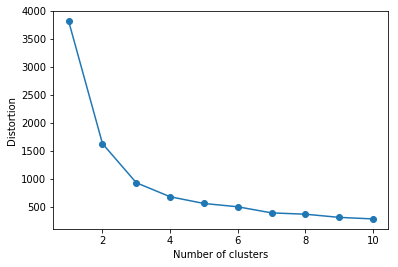

In [26]:
# Generating a graph with value of K in the range of 1 to 11  

neighborhood_grouped_clustering = neighborhood_grouped.drop('Neighborhood', 1)

distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(neighborhood_grouped_clustering)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()


Using the elbow method we need to determine the value of K from above observation.

In [27]:
# setting number of clusters based on elbow method from above observation
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(neighborhood_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 0, 2, 2, 0, 2, 0, 2, 2], dtype=int32)

In [28]:
# add clustering labels

neighborhood_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

neighborhood_grouped.head()

,Cluster Labels,Neighborhood,Bank,Hospital,Park,School,Shopping Mall
0,2,Agincourt,0,0,0,0,2
1,2,"Alderwood, Long Branch",2,0,0,1,1
2,0,"Bathurst Manor, Wilson Heights, Downsview North",2,0,3,1,0
3,2,Bayview Village,0,0,1,0,1
4,2,"Bedford Park, Lawrence Manor East",0,1,0,2,0


In [29]:
# Merging with main Data Set

df_toronto_merged = df_toronto

# merging neighborhood_grouped with df_toronto to add latitude/longitude for each neighborhood
df_toronto_merged = df_toronto_merged.join(neighborhood_grouped.set_index('Neighborhood'), on='Neighbourhood')

df_toronto_merged.dropna(inplace=True)
df_toronto_merged['Cluster Labels'] = df_toronto_merged['Cluster Labels'].astype(int)

print ('Dataframe size: ', df_toronto_merged.shape, '\nDatatypes:\n', df_toronto_merged.dtypes)
df_toronto_merged # check the last columns!

Dataframe size:  (91, 11) 
Datatypes:
 PostalCode         object
Borough            object
Neighbourhood      object
Latitude          float64
Longitude         float64
Cluster Labels      int64
Bank              float64
Hospital          float64
Park              float64
School            float64
Shopping Mall     float64
dtype: object


,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,Bank,Hospital,Park,School,Shopping Mall
0,M3A,North York,Parkwoods,43.753259,-79.329656,2,0.0,0.0,1.0,0.0,0.0
1,M4A,North York,Victoria Village,43.725882,-79.315572,2,0.0,0.0,0.0,1.0,0.0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,4.0,1.0,4.0,0.0,0.0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,2,0.0,0.0,0.0,2.0,0.0
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,3,5.0,22.0,5.0,1.0,1.0
7,M3B,North York,Don Mills,43.745906,-79.352188,2,0.0,0.0,2.0,2.0,0.0
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,2,1.0,0.0,1.0,1.0,0.0
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1,11.0,10.0,3.0,1.0,2.0
10,M6B,North York,Glencairn,43.709577,-79.445073,2,0.0,0.0,1.0,0.0,0.0
11,M9B,Etobicoke,"West Deane Park, Princess Gardens, Martin Grov...",43.650943,-79.554724,2,0.0,0.0,1.0,2.0,0.0


### Visualizing Clusters

In [30]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = ['red','blue','green','yellow']
for lat, lon, poi, cluster in zip(df_toronto_merged['Latitude'], df_toronto_merged['Longitude'], df_toronto_merged['Neighbourhood'], df_toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=markers_colors[cluster],
        fill=True,
        fill_color=markers_colors[cluster],
        fill_opacity=1).add_to(map_clusters)
    
map_clusters

From the above cluster map we can infer that clusters have a pattern. Neighborhoods closer to the city center are clustered togather and neighborhood in the outskirts have similar features.
This could be because city centre would have more commercial establisments like banks and hospitals. 

## Examining Clusters

**Cluster 0**

In [31]:
df_toronto_merged.loc[df_toronto_merged['Cluster Labels'] == 0, df_toronto_merged.columns[[2] + list(range(5, df_toronto_merged.shape[1]))]].head()

,Neighbourhood,Cluster Labels,Bank,Hospital,Park,School,Shopping Mall
2,"Regent Park, Harbourfront",0,4.0,1.0,4.0,0.0,0.0
19,The Beaches,0,2.0,0.0,3.0,4.0,1.0
20,Berczy Park,0,9.0,0.0,5.0,0.0,1.0
23,Leaside,0,4.0,0.0,1.0,4.0,0.0
28,"Bathurst Manor, Wilson Heights, Downsview North",0,2.0,0.0,3.0,1.0,0.0


**Cluster 1**

In [32]:
df_toronto_merged.loc[df_toronto_merged['Cluster Labels'] == 1, df_toronto_merged.columns[[2] + list(range(5, df_toronto_merged.shape[1]))]].head()

,Neighbourhood,Cluster Labels,Bank,Hospital,Park,School,Shopping Mall
9,"Garden District, Ryerson",1,11.0,10.0,3.0,1.0,2.0
15,St. James Town,1,15.0,9.0,6.0,0.0,2.0
30,"Richmond, Adelaide, King",1,22.0,2.0,6.0,1.0,2.0
42,"Toronto Dominion Centre, Design Exchange",1,17.0,0.0,8.0,2.0,2.0
48,"Commerce Court, Victoria Hotel",1,17.0,3.0,9.0,2.0,2.0


Cluster 1 neighborhoods have more number of Banks nearby which indicates that these neighborhoods are mostly commercial. 

Cluster 2

In [33]:
df_toronto_merged.loc[df_toronto_merged['Cluster Labels'] == 2, df_toronto_merged.columns[[2] + list(range(5, df_toronto_merged.shape[1]))]].head()

,Neighbourhood,Cluster Labels,Bank,Hospital,Park,School,Shopping Mall
0,Parkwoods,2,0.0,0.0,1.0,0.0,0.0
1,Victoria Village,2,0.0,0.0,0.0,1.0,0.0
3,"Lawrence Manor, Lawrence Heights",2,0.0,0.0,0.0,2.0,0.0
7,Don Mills,2,0.0,0.0,2.0,2.0,0.0
8,"Parkview Hill, Woodbine Gardens",2,1.0,0.0,1.0,1.0,0.0


Cluster 3

In [34]:
df_toronto_merged.loc[df_toronto_merged['Cluster Labels'] == 3, df_toronto_merged.columns[[2] + list(range(5, df_toronto_merged.shape[1]))]].head()

,Neighbourhood,Cluster Labels,Bank,Hospital,Park,School,Shopping Mall
4,"Queen's Park, Ontario Provincial Government",3,5.0,22.0,5.0,1.0,1.0
24,Central Bay Street,3,12.0,23.0,3.0,1.0,2.0


Cluster 3 neighborhoods have more number of Hospital nearby which indicates that these neighborhoods have more hosiptals. High numbers also may indicate hospital in this neighborhood may have multiple wings. 

## Fetching population data

In [35]:
df_population = pd.read_csv('https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Tables/CompFile.cfm?Lang=Eng&T=1201&OFT=FULLCSV')

df_population.head(5)

,Geographic code,Geographic name,Province or territory,"Incompletely enumerated Indian reserves and Indian settlements, 2016","Population, 2016","Total private dwellings, 2016","Private dwellings occupied by usual residents, 2016"
0,01,Canada,NaN,T,35151728.0,15412443.0,14072079.0
1,A0A,A0A,Newfoundland and Labrador,NaN,46587.0,26155.0,19426.0
2,A0B,A0B,Newfoundland and Labrador,NaN,19792.0,13658.0,8792.0
3,A0C,A0C,Newfoundland and Labrador,NaN,12587.0,8010.0,5606.0
4,A0E,A0E,Newfoundland and Labrador,NaN,22294.0,12293.0,9603.0


In [36]:
# Transform the dataframe

df_population = df_population[['Geographic code', 'Population, 2016', 'Total private dwellings, 2016']]

df_population.columns = ['Geographic code', 'Population 2016', 'Total Dwellings']


df_population.head()

,Geographic code,Population 2016,Total Dwellings
0,01,35151728.0,15412443.0
1,A0A,46587.0,26155.0
2,A0B,19792.0,13658.0
3,A0C,12587.0,8010.0
4,A0E,22294.0,12293.0


In [37]:
# Merging dataframes

df_toronto_pop = pd.merge(df_toronto_merged, df_population, left_on='PostalCode', right_on='Geographic code', copy=True, indicator=False)
df_toronto_pop = df_toronto_pop.drop(['Geographic code'], axis=1)

print ('Dataframe size: ', df_toronto_pop.shape)
df_toronto_pop.head()

Dataframe size:  (90, 13)


,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,Bank,Hospital,Park,School,Shopping Mall,Population 2016,Total Dwellings
0,M3A,North York,Parkwoods,43.753259,-79.329656,2,0.0,0.0,1.0,0.0,0.0,34615.0,13847.0
1,M4A,North York,Victoria Village,43.725882,-79.315572,2,0.0,0.0,0.0,1.0,0.0,14443.0,6299.0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,4.0,1.0,4.0,0.0,0.0,41078.0,24186.0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,2,0.0,0.0,0.0,2.0,0.0,21048.0,8751.0
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,3,5.0,22.0,5.0,1.0,1.0,10.0,6.0


### Analysing data against Clusters 

In [38]:
# Grouping the DataFrame by features of Neighbourhood

# grouped by average
df_toronto_grouped_mean = df_toronto_pop.drop(['PostalCode', 'Latitude', 'Longitude',], axis=1).groupby('Cluster Labels').mean().reset_index()

# grouped by sum
df_toronto_grouped_sum = df_toronto_pop.drop(['PostalCode', 'Latitude', 'Longitude',], axis=1).groupby('Cluster Labels').sum().reset_index() 

df_toronto_grouped_mean.head()

,Cluster Labels,Bank,Hospital,Park,School,Shopping Mall,Population 2016,Total Dwellings
0,0,3.300000,0.300000,4.300000,1.500000,0.60,31213.000000,15200.050000
1,1,15.750000,3.500000,7.375000,1.250000,1.75,6029.750000,4229.875000
2,2,0.483333,0.033333,1.366667,0.683333,0.45,27374.183333,11215.633333
3,3,8.500000,22.500000,4.000000,1.000000,1.50,4216.500000,2941.000000


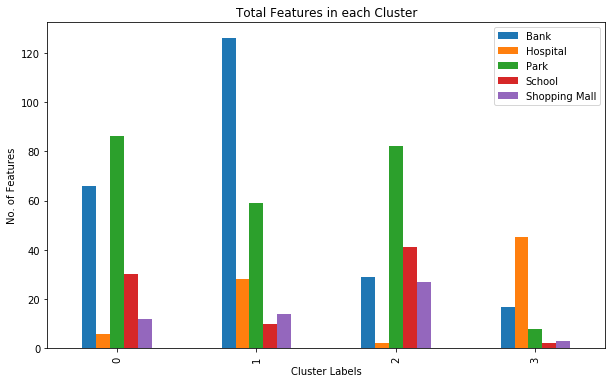

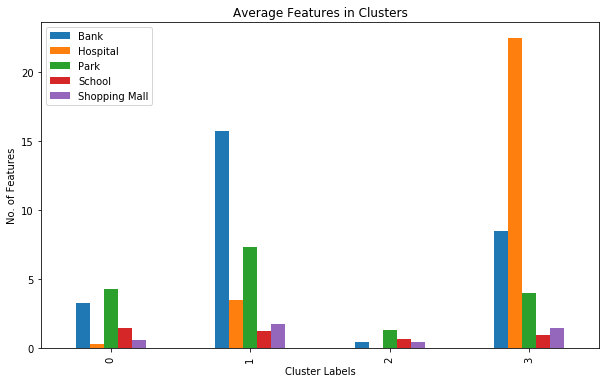

In [39]:
# Generate bar plot with total features in each cluster
df_toronto_grouped_sum.drop(['Cluster Labels','Population 2016','Total Dwellings'], axis=1).plot(kind='bar', figsize=(10, 6))

plt.xlabel('Cluster Labels') # add to x-label to the plot
plt.ylabel('No. of Features') # add y-label to the plot
plt.title('Total Features in each Cluster') # add title to the plot

plt.show()

# Generate bar plot with average features in each cluster
df_toronto_grouped_mean.drop(['Cluster Labels','Population 2016','Total Dwellings'], axis=1).plot(kind='bar', figsize=(10, 6))

plt.xlabel('Cluster Labels') # add to x-label to the plot
plt.ylabel('No. of Features') # add y-label to the plot
plt.title('Average Features in Clusters') # add title to the plot

plt.show()

From the above bar chart we can infer that clusters have a pattern.<br>
1. Neighborhoods Cluster 1 and 3 have more number of average and total commercial establishments such as Banks and Hospitals.<br>
2. In the rendered map we also saw that these clusters are closer to city center. 

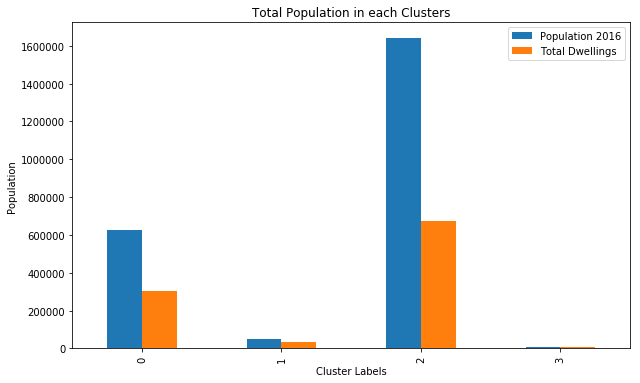

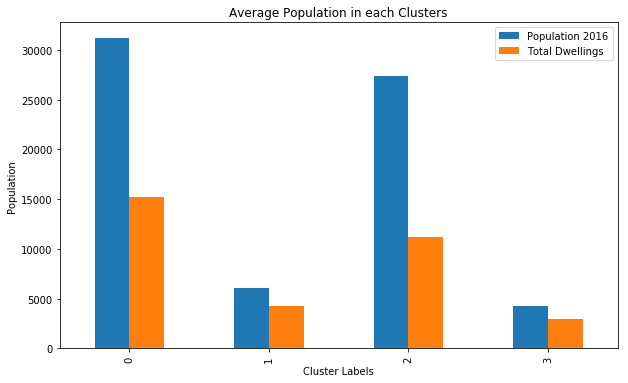

In [40]:
# Generate bar plot with total population in each cluster
df_toronto_grouped_sum.filter(['Population 2016','Total Dwellings'], axis=1).plot(kind='bar', figsize=(10, 6))

plt.xlabel('Cluster Labels') # add to x-label to the plot
plt.ylabel('Population') # add y-label to the plot
plt.title('Total Population in each Clusters') # add title to the plot

plt.show()

# Generate bar plot with average population in each cluster
df_toronto_grouped_mean.filter(['Population 2016','Total Dwellings'], axis=1).plot(kind='bar', figsize=(10, 6))

plt.xlabel('Cluster Labels') # add to x-label to the plot
plt.ylabel('Population') # add y-label to the plot
plt.title('Average Population in each Clusters') # add title to the plot

plt.show()

From the above bar chart we can establish that clusters have a patterns.<br>
1. Neighborhoods Cluster 0 and 2 have more average and total population, also lesser commercial establishments thus are residential neighborhoods.<br>
2. In the rendered map we saw that these clusters are away from city center. 

**From obsevations we can clearly establish that commercial and residentail neighbourhoods.**